In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import uniform, loguniform
from sklearn.base import clone

C:\Users\Kristian Røhne\AppData\Local\Temp\ipykernel_17476\1490444041.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data= pd.read_csv("train.csv", index_col= 0)

# Dropping the 'Unnamed: 0' and 'index' columns as they seem to be identifiers
data = data.drop(['index'], axis=1)

In [3]:
# Replace negative values with zero for specified columns
for column in ['AFP (ng/mL)', 'ALT (U/L)', 'AST (U/L)']:
    data[column] = data[column].apply(lambda x: max(x, 0))

In [4]:
# Separating features and target variable
X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

In [5]:
# Identifying numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Pipelines for preprocessing
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [6]:
# Define classifiers
svc = SVC(kernel='rbf', random_state=42)
logreg = LogisticRegression(random_state=42, solver='saga', max_iter=10000)

# Feature selection
sfs_svc = SFS(svc, k_features=(5, 20), forward=True, floating=False, scoring='f1_macro', cv=5)
sfs_logreg = SFS(logreg, k_features=(5, 20), forward=True, floating=False, scoring='f1_macro', cv=5)

sfs_svc.fit(X_train, y_train)
sfs_logreg.fit(X_train, y_train)

X_train_svc_selected = sfs_svc.transform(X_train)
X_train_logreg_selected = sfs_logreg.transform(X_train)

c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\

In [7]:
# Parameter tuning
svc_param_dist = {'C': uniform(0.1, 10), 'gamma': ['scale', 'auto'] + list(uniform(0.1, 1).rvs(size=10))}
logreg_param_dist = {'C': loguniform(1e-4, 1e2), 'penalty': ['l1', 'l2']}

svm_search = RandomizedSearchCV(svc, svc_param_dist, n_iter=50, cv=5, scoring='f1_macro', verbose=1, random_state=42, n_jobs=-1)
logreg_search = RandomizedSearchCV(logreg, logreg_param_dist, n_iter=50, cv=5, scoring='f1_macro', verbose=1, random_state=42, n_jobs=-1)

svm_search.fit(X_train_svc_selected, y_train)
logreg_search.fit(X_train_logreg_selected, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000, random_state=42,
                                                solver='saga'),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025F91135B10>,
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring='f1_macro', verbose=1)

Best model parameters: {'C': 0.944351568796268, 'penalty': 'l2'}
Best model score: 0.7722326617795916
SVM Model F1-Macro Score: 0.7258241111670093
Logistic Regression Model F1-Macro Score: 0.7980848836709826


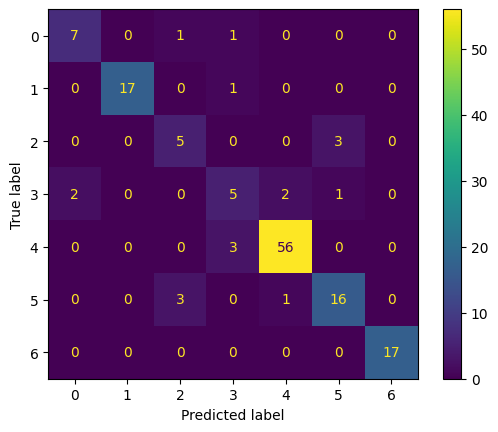

In [10]:
# Import required library for F1 score calculation
from sklearn.metrics import f1_score

# Continue from the parameter tuning and model comparison...
# Compare the best scores and keep the better search object
best_search = svm_search if svm_search.best_score_ > logreg_search.best_score_ else logreg_search

# Get the best estimator from the best search object
best_model = best_search.best_estimator_
best_params = best_search.best_params_
best_score = best_search.best_score_

print(f"Best model parameters: {best_params}")
print(f"Best model score: {best_score}")

# Choose the best feature selector based on the best model
best_sfs = sfs_svc if best_model == svm_search.best_estimator_ else sfs_logreg

# Predict and calculate F1-macro score for SVM model
X_test_svc_selected = sfs_svc.transform(X_test)
y_pred_svc = svm_search.best_estimator_.predict(X_test_svc_selected)
svc_f1_score = f1_score(y_test, y_pred_svc, average='macro')
print(f"SVM Model F1-Macro Score: {svc_f1_score}")

# Predict and calculate F1-macro score for Logistic Regression model
X_test_logreg_selected = sfs_logreg.transform(X_test)
y_pred_logreg = logreg_search.best_estimator_.predict(X_test_logreg_selected)
logreg_f1_score = f1_score(y_test, y_pred_logreg, average='macro')
print(f"Logistic Regression Model F1-Macro Score: {logreg_f1_score}")

# Evaluate the best model with the selected features
X_test_selected = best_sfs.transform(X_test)
y_pred = best_model.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


test_data = pd.read_csv("test.csv")
# Predict on new test data with the selected features for both models
test_data_preprocessed = preprocessor.transform(test_data.drop(['index'], axis=1))

# SVM Predictions
test_data_svc_selected = sfs_svc.transform(test_data_preprocessed)
svm_predictions = svm_search.best_estimator_.predict(test_data_svc_selected)
submission_df_svc = pd.DataFrame({'index': test_data.index, 'Diagnosis': svm_predictions})
submission_df_svc.to_csv('submission_svc.csv', index=False)

# Logistic Regression Predictions
test_data_logreg_selected = sfs_logreg.transform(test_data_preprocessed)
logreg_predictions = logreg_search.best_estimator_.predict(test_data_logreg_selected)
submission_df_logreg = pd.DataFrame({'index': test_data.index, 'Diagnosis': logreg_predictions})
submission_df_logreg.to_csv('submission_logreg.csv', index=False)
